In [1]:
# !pip install tensorflow_text=="2.9.*"

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns

import preprocess_utils as pre

In [37]:
print("Tensorflow version: ", tf.__version__)
print(tf.config.list_physical_devices("GPU"))

Tensorflow version:  2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
should_uncase = True

def preprocess_uncased(text):
    prep_text = []
    for sentence in text:
        prep_sentence = []
        for word in sentence:
            prep_sentence.append(word.lower())
        prep_text.append(prep_sentence)
    return prep_text

dir_path = ""

In [6]:
data = pre.read_iob_file(os.path.join(dir_path, "datasets", "conll2003", "train.txt"))
print(f"Conll2003 dataset features: {set(data.keys())}")

Conll2003 dataset features: {'chunk_tags', 'entity_tags', 'tokens', 'pos_tags'}


In [7]:
train_text = data["tokens"]
if should_uncase:
    train_text = preprocess_uncased(train_text)
train_labels = data["entity_tags"]
print(f"Train dataset: {len(train_text)}")

Train dataset: 14041


In [8]:
data = pre.read_iob_file(os.path.join(dir_path, "datasets", "conll2003", "valid.txt"))
valid_text = data["tokens"]
if should_uncase:
    valid_text = preprocess_uncased(valid_text)
valid_labels = data["entity_tags"]
print(f"Validation dataset: {len(valid_text)}")

Validation dataset: 3250


In [9]:
data = pre.read_iob_file(os.path.join(dir_path, "datasets", "conll2003", "test.txt"))
test_text = data["tokens"]
if should_uncase:
    test_text = preprocess_uncased(test_text)
test_labels = data["entity_tags"]
print(f"Test dataset: {len(test_text)}")

Test dataset: 3453


In [10]:
print(f"Sentence: {train_text[0]}")
print(f"Labels:   {train_labels[0]}")

Sentence: ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
Labels:   ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [35]:
def get_unique_labels(labels):
    unique_labels = set()
    for sentence_labels in labels:
        unique_labels.update(sentence_labels)
    return unique_labels

unique_labels = sorted(get_unique_labels(train_labels))
label_to_idx = {label: idx+1 for idx, label in enumerate(unique_labels)}
idx_to_label = {idx+1: label for idx, label in enumerate(unique_labels)}

# these tags are important to convert
# the prediction of the model to a string label
label_to_idx

{'B-LOC': 1,
 'B-MISC': 2,
 'B-ORG': 3,
 'B-PER': 4,
 'I-LOC': 5,
 'I-MISC': 6,
 'I-ORG': 7,
 'I-PER': 8,
 'O': 9}

In [12]:
MAX_SEQ_LENGTH = 30
# tokenizer for small bert
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
tokenizer = hub.KerasLayer(preprocessor.tokenize)
packer = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=MAX_SEQ_LENGTH)
)

# tokenizer for multi bert
# preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
# tokenizer = hub.KerasLayer(preprocessor.tokenize)
# packer = hub.KerasLayer(
#     preprocessor.bert_pack_inputs,
#     arguments=dict(seq_length=MAX_SEQ_LENGTH)
# )

In [13]:
special_tokens = preprocessor.tokenize.get_special_tokens_dict()
print("Special tokens:")
for key, value in special_tokens.items():
    print(f"    {key:20}: {value}")

Special tokens:
    end_of_segment_id   : 102
    start_of_sequence_id: 101
    mask_id             : 103
    padding_id          : 0
    vocab_size          : 30522


In [14]:
TOKEN_START = special_tokens["start_of_sequence_id"]
TOKEN_END = special_tokens["end_of_segment_id"]
TOKEN_PAD = special_tokens["padding_id"]

batch_size = 32

In [34]:
# Merge the last two dimensions of the tokens and
# compute in how many subtoken a word was divided
def merge_dims_and_get_tokens_length(tokens):
    tokens = tokens.merge_dims(-2, -1)
    num_subtokens_per_token = tf.map_fn(lambda token: tf.size(token), tokens, fn_output_signature=tf.int32)
    return tokens, num_subtokens_per_token

# Build a lookup table for labels
init = tf.lookup.KeyValueTensorInitializer(
    keys=unique_labels,
    values=tf.range(1, len(unique_labels) + 1, dtype=tf.int64)
)
table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets=1)

def preprocess_dataset(tokens_info, labels):
    tokens, num_subtokens_per_token = tokens_info
    
    # Bert packer works on batches so a new dimension is necessary
    tokens = tf.expand_dims(tokens, axis=0)
    packed_tokens = packer([tokens])
    # The bert packer already has the output as a batch. This is necessary because
    # we are preprocessing a list of string words (a sentence) instead of a list of
    # string sentences. Thus if we want to batch this sentences we have to reshape.
    packed_tokens["input_word_ids"] = tf.reshape(packed_tokens["input_word_ids"], (-1,))
    packed_tokens["input_type_ids"] = tf.reshape(packed_tokens["input_type_ids"], (-1,))
    packed_tokens["input_mask"] = tf.reshape(packed_tokens["input_mask"], (-1,))
    
    # Convert labels to ids and aligne them to the number of subtokens
    labels_ids = table.lookup(labels)
    aligned_labels_ids = tf.repeat(labels_ids, num_subtokens_per_token)
    # The first token in packed tokens is TOKEN_START and the last is TOKEN_END
    # Also the packed tokens are padded to MAX_SEQUENCE_LENGTH
    logical_pos = tf.logical_and(
        tf.not_equal(packed_tokens["input_word_ids"], TOKEN_START),
        tf.not_equal(packed_tokens["input_word_ids"], TOKEN_END)
    )
    logical_pos = tf.logical_and(
        logical_pos,
        tf.not_equal(packed_tokens["input_word_ids"], TOKEN_PAD)
    )
    
    shape = packed_tokens["input_word_ids"].shape
    # When the labels are of length MAX_SEMAX_SEQ_LENGTH ingnore the last
    # two labels because they are also discarded by the bert packer in favor
    # of the START_TOKEN and END_TOKEN
    labels_end_index = MAX_SEQ_LENGTH - 2
    aligned_labels_ids = tf.scatter_nd(
        tf.where(logical_pos),
        aligned_labels_ids[:labels_end_index],
        shape
    )
    return packed_tokens, aligned_labels_ids


In [16]:
# Train dataset
train_text_ragged_tensors = tf.ragged.constant(train_text)
train_labels_ragged_tensors = tf.ragged.constant(train_labels)

train_text_dataset = (tf.data.Dataset.from_tensor_slices(train_text_ragged_tensors)
                .map(lambda text: tokenizer(text))
                .map(merge_dims_and_get_tokens_length)
               )

train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels_ragged_tensors)

train_dataset = (tf.data.Dataset.zip((train_text_dataset, train_labels_dataset))
                 .map(preprocess_dataset)
                 .batch(batch_size)
                 .cache()
                )

# Validation dataset
valid_text_ragged_tensors = tf.ragged.constant(valid_text)
valid_labels_ragged_tensors = tf.ragged.constant(valid_labels)

valid_text_dataset = (tf.data.Dataset.from_tensor_slices(valid_text_ragged_tensors)
                .map(lambda text: tokenizer(text))
                .map(merge_dims_and_get_tokens_length)
               )

valid_labels_dataset = tf.data.Dataset.from_tensor_slices(valid_labels_ragged_tensors)

valid_dataset = (tf.data.Dataset.zip((valid_text_dataset, valid_labels_dataset))
                 .map(preprocess_dataset)
                 .batch(batch_size)
                 .cache()
                )

# Test dataset
test_text_ragged_tensors = tf.ragged.constant(test_text)
test_labels_ragged_tensors = tf.ragged.constant(test_labels)

test_text_dataset = (tf.data.Dataset.from_tensor_slices(test_text_ragged_tensors)
                .map(lambda text: tokenizer(text))
                .map(merge_dims_and_get_tokens_length)
               )

test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels_ragged_tensors)

test_dataset = (tf.data.Dataset.zip((test_text_dataset, test_labels_dataset))
                 .map(preprocess_dataset)
                 .batch(batch_size)
                 .cache()
                )

In [17]:
class IgnorePaddingSparseCategoricalCrossentropyLoss(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, **kwargs):
        super(IgnorePaddingSparseCategoricalCrossentropyLoss, self).__init__(**kwargs)
        self.from_logits = from_logits
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=self.from_logits,
            reduction=tf.keras.losses.Reduction.NONE
        )
    
    def call(self, y_true, y_pred):
        loss = self.loss_fn(y_true, y_pred)
        mask = tf.cast(tf.not_equal(y_true,  0), dtype=tf.dtypes.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "from_logits": self.from_logits
        })
        return config

In [18]:
class IgnorePaddingSparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="accuracy", **kwargs):
        super(IgnorePaddingSparseCategoricalAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        labels = tf.math.argmax(y_pred, axis=2)
        mask = tf.not_equal(y_true, 0)
        correct_predictions = tf.equal(y_true, labels)
        correct_predictions = tf.cast(tf.logical_and(mask, correct_predictions),
                                      dtype=tf.dtypes.float32)
        total_labels = tf.cast(mask, dtype=tf.dtypes.float32)
        self.count.assign_add(tf.reduce_sum(correct_predictions))
        self.total.assign_add(tf.reduce_sum(total_labels))
    
    def result(self):
        return self.count / self.total
    
    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
    
    def get_config(self):
        config = super().get_config()
        return config

In [19]:
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2",
    trainable=True
)

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/2",
#     trainable=True
# )

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2",
#     trainable=True
# )

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2",
#     trainable=True
# )

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/2",
#     trainable=True
# )

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4",
#     trainable=True
# )

In [20]:
encoder_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32),
    input_mask=tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32),
    input_type_ids=tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32),
)
encoder_outputs = encoder(encoder_inputs)
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(unique_labels) + 1))(encoder_outputs["sequence_output"])

model = tf.keras.Model(inputs=encoder_inputs, outputs=outputs)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'sequence_output':  11170561    ['input_2[0][0]',                
                                 (None, 30, 256),                 'input_3[0][0]',            

In [22]:
epochs = 50
train_data_size = len(train_text)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
initial_learning_rate = 2e-5
end_learning_rate = 1e-9

linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=end_learning_rate,
    decay_steps=num_train_steps
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(linear_decay),
    loss=IgnorePaddingSparseCategoricalCrossentropyLoss(from_logits=True),
    metrics=[IgnorePaddingSparseCategoricalAccuracy()]
)

In [23]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=0.01
    )]
)

Epoch 1/50
439/439 [==============================] - 90s 192ms/step - loss: 0.5466 - accuracy: 0.8436 - val_loss: 0.2497 - val_accuracy: 0.9236
Epoch 2/50
439/439 [==============================] - 144s 329ms/step - loss: 0.2427 - accuracy: 0.9251 - val_loss: 0.1638 - val_accuracy: 0.9487
Epoch 3/50
439/439 [==============================] - 167s 381ms/step - loss: 0.1764 - accuracy: 0.9436 - val_loss: 0.1354 - val_accuracy: 0.9564
Epoch 4/50
439/439 [==============================] - 171s 389ms/step - loss: 0.1434 - accuracy: 0.9534 - val_loss: 0.1204 - val_accuracy: 0.9612
Epoch 5/50
439/439 [==============================] - 185s 421ms/step - loss: 0.1182 - accuracy: 0.9609 - val_loss: 0.1114 - val_accuracy: 0.9641
Epoch 6/50
439/439 [==============================] - 208s 474ms/step - loss: 0.1020 - accuracy: 0.9661 - val_loss: 0.1064 - val_accuracy: 0.9654
Epoch 7/50
439/439 [==============================] - 198s 450ms/step - loss: 0.0887 - accuracy: 0.9701 - val_loss: 0.1014 - 

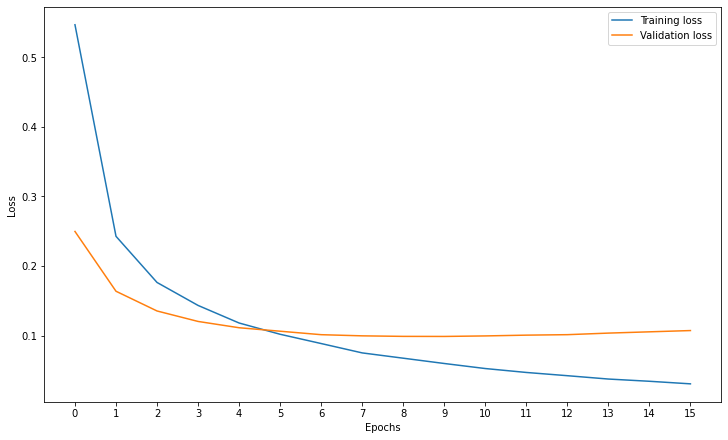

In [24]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

ax.plot(history.history["loss"], label="Training loss")
ax.plot(history.history["val_loss"], label="Validation loss")
# index_min_val_loss = np.argmin(history.history["val_loss"])
# min_val_loss = history.history["val_loss"][index_min_val_loss]
# ax.plot([index_min_val_loss], [min_val_loss], marker="o", color="C1")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(len(history.history["loss"])))
ax.legend()
plt.savefig("loss.png")

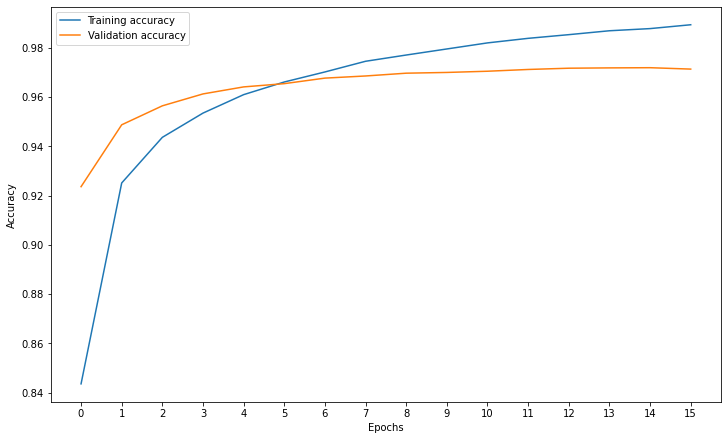

In [25]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

ax.plot(history.history["accuracy"], label="Training accuracy")
ax.plot(history.history["val_accuracy"], label="Validation accuracy")
# index_max_val_accuracy = np.argmax(history.history["val_accuracy"])
# max_val_accuracy = history.history["val_accuracy"][index_min_val_loss]
# ax.plot([index_max_val_accuracy], [max_val_accuracy], marker="o", color="C1")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_xticks(np.arange(len(history.history["accuracy"])))
ax.legend()
plt.savefig("accuracy.png")

In [26]:
metrics = model.evaluate(test_dataset)

for metric_name, metric in zip(model.metrics_names, metrics):
    print(f"{metric_name:<8s}: {metric:.4f}")

108/108 [==============================] - 9s 73ms/step - loss: 0.1826 - accuracy: 0.9604
loss    : 0.1826
accuracy: 0.9604


In [27]:
y_true = []
for tokens, labels in test_dataset:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true, axis=0)

predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=2)

y_pred_raveled = y_pred[y_true != 0]
y_true_raveled = y_true[y_true != 0]

accuracy = accuracy_score(y_true_raveled, y_pred_raveled)
precision = precision_score(y_true_raveled, y_pred_raveled, average="macro")
recall = recall_score(y_true_raveled, y_pred_raveled, average="macro")
f1score = f1_score(y_true_raveled, y_pred_raveled, average="macro")
print(f"accuracy : {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall   : {recall:.4f}")
print(f"F1       : {f1score:.4f}")

108/108 [==============================] - 15s 132ms/step
accuracy : 0.9604
precision: 0.8098
recall   : 0.8347
F1       : 0.8211


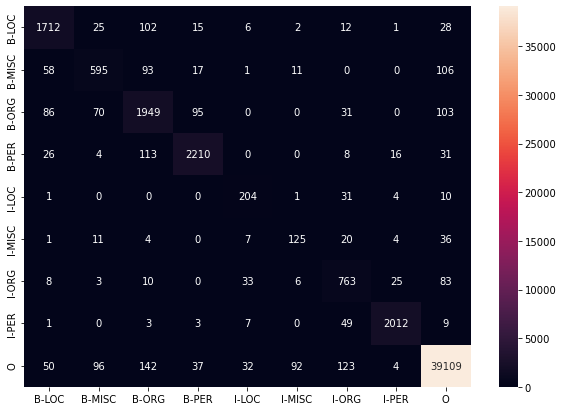

In [28]:
matrix = confusion_matrix(y_true_raveled, y_pred_raveled)
df = pd.DataFrame(matrix, index=unique_labels, columns=unique_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(df, annot=True, fmt="d")
plt.savefig("confusion_matrix.png")

In [29]:
class SentencePreprocesser(tf.keras.layers.Layer):
    def __init__(self, tokenizer, packer):
        super(SentencePreprocesser, self).__init__()
        self.tokenizer = tokenizer
        self.packer = packer
    
    def call(self, inputs):
        tokens = self.tokenizer(inputs)
        tokens = tokens.merge_dims(-2, -1)
        tokens = tf.expand_dims(tokens, axis=0)
        tokens = packer([tokens])
        return tokens
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "tokenizer": self.tokenizer,
            "packer": self.packer
        })
        return config

In [30]:
model.compile()

inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
x = SentencePreprocesser(tokenizer, packer)(inputs)
outputs = model(x)
ner_model = tf.keras.Model(inputs=inputs, outputs=outputs)
ner_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 sentence_preprocesser (Sentenc  {'input_word_ids':   0          ['input_4[0][0]']                
 ePreprocesser)                 (1, 30),                                                          
                                 'input_type_ids':                                                
                                (1, 30),                                                          
                                 'input_mask': (1,                                                
                                30)}                                                        

In [31]:
ner_model.compile()
ner_model.save("ner_model")

INFO:tensorflow:Assets written to: ner_model\assets


INFO:tensorflow:Assets written to: ner_model\assets


In [32]:
# !zip -r ner_model.zip ner_model/

In [33]:
# from google.colab import files
# files.download("ner_model.zip")
# files.download("loss.png")
# files.download("accuracy.png")
# files.download("confusion_matrix.png")